In [1085]:
import pandas as pd
import numpy as np

# Number of mock entries
num_entries = 10000

# Generate random data
np.random.seed(42)  # For reproducibility
user_ids = np.random.randint(1, 101, num_entries)
num_bets = np.random.randint(2, 7, num_entries)  # Number of bets in each parlay (2 to 6)
bet_amounts = np.round(np.random.uniform(10, 500, num_entries), 2)

# Create a DataFrame
df_mock = pd.DataFrame({
    'User_ID': user_ids,
    'Num_Bets': num_bets,
    'Bet_Amount': bet_amounts
})

# Function to generate random American odds from a predefined set
def generate_random_odds(num_bets):
    predefined_odds = [-500, -450, -400, -200, -150, -120, -105, 100, 105, 110, 115, 180, 220, 300, 400, 500]
    strategy = np.random.choice(['all_favorites', 'all_underdogs', 'mix'], p=[0.2, 0.2, 0.6])
    
    if strategy == 'all_favorites':
        odds = np.random.choice([odd for odd in predefined_odds if odd < 0], num_bets)
    elif strategy == 'all_underdogs':
        odds = np.random.choice([odd for odd in predefined_odds if odd > 0], num_bets)
    else:  # mix
        odds = np.random.choice(predefined_odds, num_bets)
    
    return odds

# Apply the function to generate random odds for each entry
df_mock['Odds'] = df_mock['Num_Bets'].apply(generate_random_odds)

# Function to convert American odds to implied probability
def american_to_implied_probability(odds):
    if odds > 0:
        return 100 / (odds + 100)
    else:
        return abs(odds) / (abs(odds) + 100)

# Calculate implied probabilities for each bet
df_mock['Implied_Probabilities'] = df_mock['Odds'].apply(lambda x: [american_to_implied_probability(odd) for odd in x])

# Function to calculate combined implied probability and combined odds
def calculate_combined_odds(implied_probabilities):
    combined_probability = np.prod(implied_probabilities)
    combined_odds = 1 / combined_probability if combined_probability != 0 else np.inf
    return combined_probability, combined_odds

# Apply the function to calculate combined implied probability and combined odds
df_mock[['Combined_Probability', 'Combined_Odds']] = df_mock['Implied_Probabilities'].apply(lambda x: pd.Series(calculate_combined_odds(x)))

# Function to calculate the vig
def calculate_vig(implied_probabilities):
    total_implied_probability = sum(implied_probabilities)
    vig = total_implied_probability - 1
    return vig

# Apply the function to calculate the vig for each entry
df_mock['Vig'] = df_mock['Implied_Probabilities'].apply(calculate_vig)

# Function to determine the outcome based on combined probability
def determine_outcome(probability):
    return np.random.choice(['Win', 'Loss'], p=[probability, 1 - probability])

# Apply the function to determine the outcome for each entry
df_mock['Overall_Result'] = df_mock['Combined_Probability'].apply(determine_outcome)

# Calculate payouts and profits based on the overall result
def calculate_payout(row):
    if row['Overall_Result'] == 'Win':
        return row['Bet_Amount'] * row['Combined_Odds']
    else:
        return 0

def calculate_profit(row):
    commission = row['Bet_Amount'] * 0.10  # 10% commission fee
    return row['Payout'] - row['Bet_Amount'] + commission

# Apply the functions to calculate payouts and profits
df_mock['Payout'] = df_mock.apply(calculate_payout, axis=1)
df_mock['Profit'] = df_mock.apply(calculate_profit, axis=1)
df_mock['Commission'] = df_mock['Bet_Amount'] * 0.10  # Add commission column

# Calculate average vig and average combined odds
average_vig = df_mock['Vig'].mean()
average_combined_odds = df_mock['Combined_Odds'].mean()

print(f"Average Vig: {average_vig}")
print(f"Average Combined Odds: {average_combined_odds}")

# Define the file name
file_name = 'mock_betting_data.csv'

# Export the DataFrame to CSV in the current directory
df_mock.to_csv(file_name, index=False)

print(f"DataFrame exported to {file_name} in the current directory")

Average Vig: 1.026489198348447
Average Combined Odds: 125.37828898118865
DataFrame exported to mock_betting_data.csv in the current directory


         Total_Bets  Total_Amount_Bet  Average_Bet_Amount  Total_Profit  Wins  \
User_ID                                                                         
1                97          27256.65          280.996392  19340.162717    15   
2               110          28384.21          258.038273   1104.144627    12   
3                99          27520.74          277.987273  -2832.340841    16   
4               103          25456.06          247.146214 -10944.969353    15   
5                87          24612.14          282.898161 -13429.090964     9   

         Losses  Win_Loss_Ratio  
User_ID                          
1            82        0.182927  
2            98        0.122449  
3            83        0.192771  
4            88        0.170455  
5            78        0.115385  


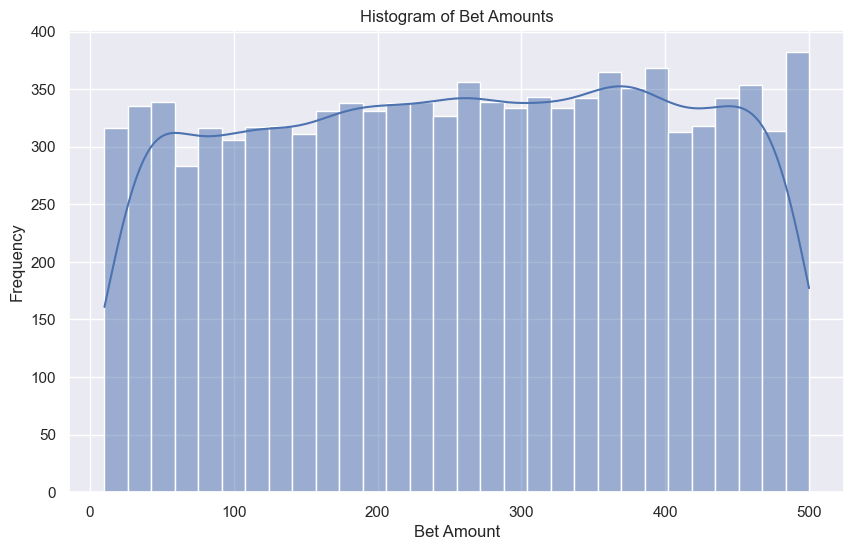

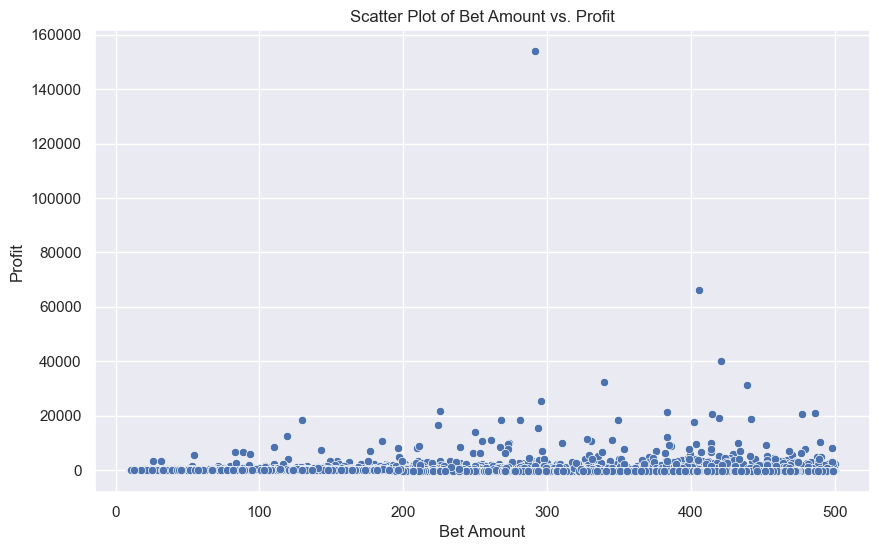

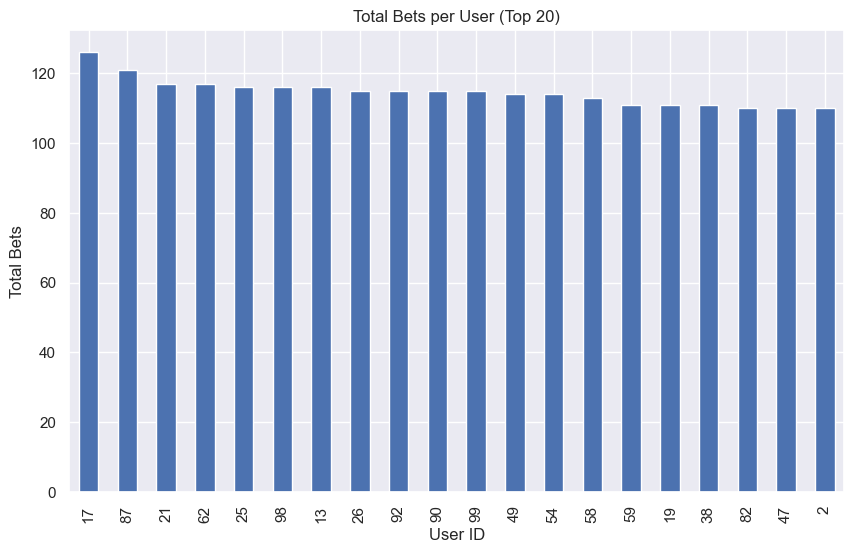

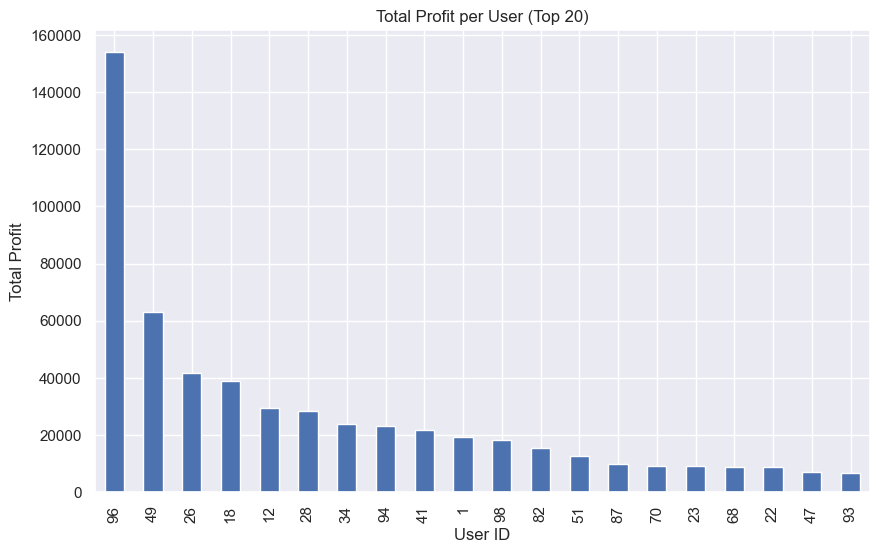

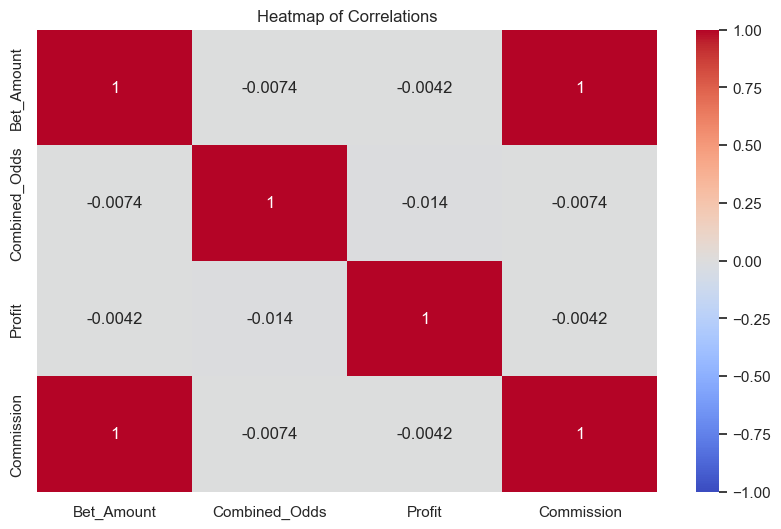

In [1086]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_mock is already created and contains the necessary data

# Aggregate Data Analysis
# Total Bets and Total Amount Bet per User
user_aggregate = df_mock.groupby('User_ID').agg(
    Total_Bets=('User_ID', 'count'),
    Total_Amount_Bet=('Bet_Amount', 'sum'),
    Average_Bet_Amount=('Bet_Amount', 'mean'),
    Total_Profit=('Profit', 'sum'),
    Wins=('Overall_Result', lambda x: (x == 'Win').sum()),
    Losses=('Overall_Result', lambda x: (x == 'Loss').sum())
)

# Calculate Win/Loss Ratio
user_aggregate['Win_Loss_Ratio'] = user_aggregate['Wins'] / user_aggregate['Losses']

# Display the aggregate data
print(user_aggregate.head())

# Visualizations
# Histogram of Bet Amounts
plt.figure(figsize=(10, 6))
sns.histplot(df_mock['Bet_Amount'], bins=30, kde=True)
plt.title('Histogram of Bet Amounts')
plt.xlabel('Bet Amount')
plt.ylabel('Frequency')
plt.show()

# Scatter Plot of Bet Amount vs. Profit
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Bet_Amount', y='Profit', data=df_mock)
plt.title('Scatter Plot of Bet Amount vs. Profit')
plt.xlabel('Bet Amount')
plt.ylabel('Profit')
plt.show()

# Bar Plot of Total Bets per User
plt.figure(figsize=(10, 6))
user_aggregate['Total_Bets'].sort_values(ascending=False).head(20).plot(kind='bar')
plt.title('Total Bets per User (Top 20)')
plt.xlabel('User ID')
plt.ylabel('Total Bets')
plt.show()

# Bar Plot of Total Profit per User
plt.figure(figsize=(10, 6))
user_aggregate['Total_Profit'].sort_values(ascending=False).head(20).plot(kind='bar')
plt.title('Total Profit per User (Top 20)')
plt.xlabel('User ID')
plt.ylabel('Total Profit')
plt.show()

# Heatmap of Correlations
plt.figure(figsize=(10, 6))
correlation_matrix = df_mock[['Bet_Amount', 'Combined_Odds', 'Profit', 'Commission']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap of Correlations')
plt.show()

In [1087]:
user_96_data = df_mock[df_mock['User_ID'] == 96]

In [1088]:
user_96_data = df_mock[(df_mock['User_ID'] == 96) & (df_mock['Payout'] > 0)]

In [1089]:
user_96_data.head(20)

,User_ID,Num_Bets,Bet_Amount,Odds,Implied_Probabilities,Combined_Probability,Combined_Odds,Vig,Overall_Result,Payout,Profit,Commission
747,96,2,280.37,"[-400, -200]","[0.8, 0.6666666666666666]",0.533333,1.875000,0.466667,Win,525.693750,273.360750,28.037
1381,96,6,291.57,"[-105, 110, 100, 115, 500, 400]","[0.5121951219512195, 0.47619047619047616, 0.5,...",0.001891,528.900000,1.320169,Win,154211.373000,153948.960000,29.157
1820,96,2,462.50,"[-400, 115]","[0.8, 0.46511627906976744]",0.372093,2.687500,0.265116,Win,1242.968750,826.718750,46.250
1836,96,2,96.51,"[115, 180]","[0.46511627906976744, 0.35714285714285715]",0.166113,6.020000,-0.177741,Win,580.990200,494.131200,9.651
4238,96,3,96.45,"[180, 110, -200]","[0.35714285714285715, 0.47619047619047616, 0.6...",0.113379,8.820000,0.500000,Win,850.689000,763.884000,9.645
4332,96,2,162.97,"[-105, 180]","[0.5121951219512195, 0.35714285714285715]",0.182927,5.466667,-0.130662,Win,890.902667,744.229667,16.297
5249,96,2,42.26,"[100, -400]","[0.5, 0.8]",0.400000,2.500000,0.300000,Win,105.650000,67.616000,4.226
5319,96,3,487.81,"[100, -150, 220]","[0.5, 0.6, 0.3125]",0.093750,10.666667,0.412500,Win,5203.306667,4764.277667,48.781
5536,96,3,54.10,"[-120, 110, -150]","[0.5454545454545454, 0.47619047619047616, 0.6]",0.155844,6.416667,0.621645,Win,347.141667,298.451667,5.410
6898,96,3,103.61,"[-400, -500, -450]","[0.8, 0.8333333333333334, 0.8181818181818182]",0.545455,1.833333,1.451515,Win,189.951667,96.702667,10.361


In [1090]:
print(df_mock.head())

   User_ID  Num_Bets  Bet_Amount                                  Odds  \
0       52         6       81.33  [-120, -120, -150, -450, -150, -450]   
1       93         6      417.26      [105, 300, -120, 100, 110, -400]   
2       15         2      180.86                           [-200, 180]   
3       72         5      206.07        [-400, -200, -150, -500, -500]   
4       61         3      448.09                       [115, 500, 180]   

                               Implied_Probabilities  Combined_Probability  \
0  [0.5454545454545454, 0.5454545454545454, 0.6, ...              0.071700   
1  [0.4878048780487805, 0.25, 0.5454545454545454,...              0.012670   
2          [0.6666666666666666, 0.35714285714285715]              0.238095   
3  [0.8, 0.6666666666666666, 0.6, 0.8333333333333...              0.222222   
4  [0.46511627906976744, 0.16666666666666666, 0.3...              0.027685   

   Combined_Odds       Vig Overall_Result   Payout   Profit  Commission  
0      13.94

Correlation Matrix:
                Payout  Average_Odds
Payout        1.000000     -0.005147
Average_Odds -0.005147      1.000000


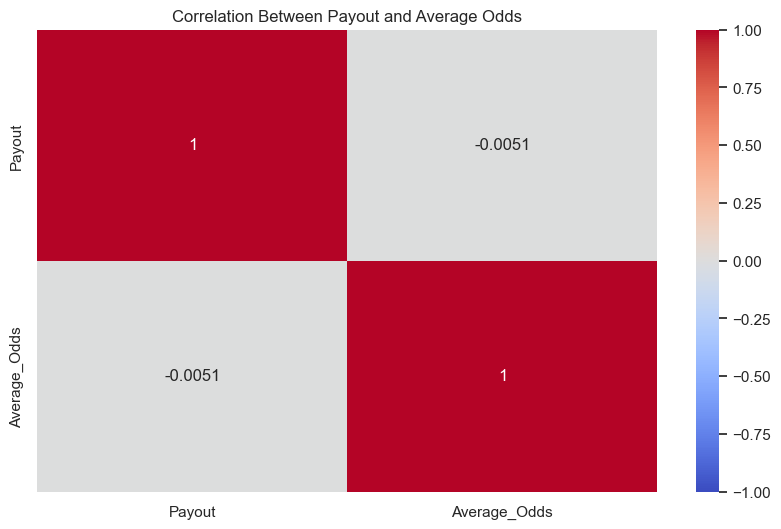

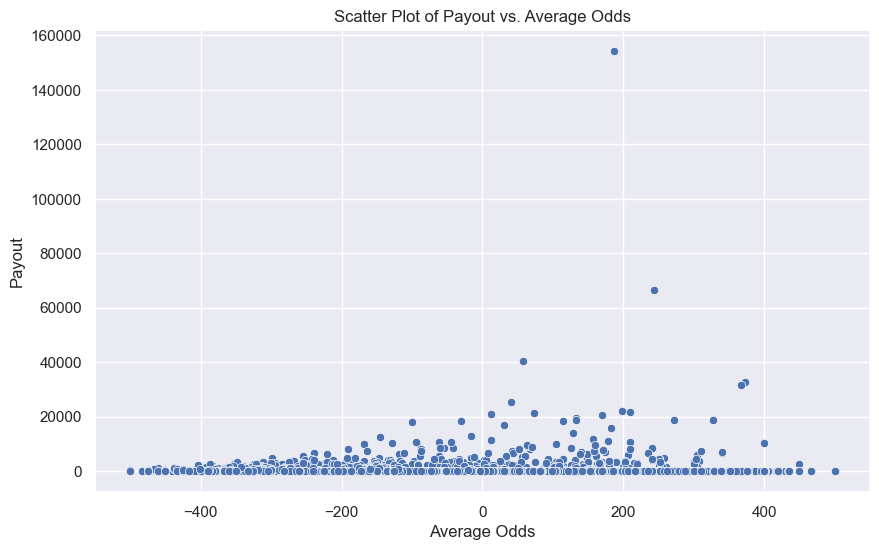

In [1091]:
# Calculate Average Odds for Each Entry
df_mock['Average_Odds'] = df_mock['Odds'].apply(lambda x: np.mean(x))

# Perform Correlation Analysis Between Payout and Average Odds
correlation = df_mock[['Payout', 'Average_Odds']].corr()

# Display the Correlation Matrix
print("Correlation Matrix:")
print(correlation)

# Visualize the Correlation
plt.figure(figsize=(10, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Between Payout and Average Odds')
plt.show()

# Scatter Plot of Payout vs. Average Odds
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Average_Odds', y='Payout', data=df_mock)
plt.title('Scatter Plot of Payout vs. Average Odds')
plt.xlabel('Average Odds')
plt.ylabel('Payout')
plt.show()

C:\Users\Mitch\AppData\Local\Temp\ipykernel_27800\2615755013.py:12: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_mock.corr()


Correlation Matrix:
                       User_ID  Num_Bets  Bet_Amount  Combined_Probability  \
User_ID               1.000000  0.019268    0.011291             -0.014616   
Num_Bets              0.019268  1.000000   -0.002152             -0.590126   
Bet_Amount            0.011291 -0.002152    1.000000              0.024266   
Combined_Probability -0.014616 -0.590126    0.024266              1.000000   
Combined_Odds        -0.008192  0.265896   -0.007398             -0.193010   
Vig                   0.018260  0.786559    0.011969             -0.130832   
Payout                0.006119 -0.014192    0.056127              0.009047   
Profit                0.005446 -0.014084   -0.004238              0.007595   
Commission            0.011291 -0.002152    1.000000              0.024266   
Average_Odds         -0.001556  0.009885   -0.027428             -0.681607   

                      Combined_Odds       Vig    Payout    Profit  Commission  \
User_ID                   -0.008192  0.0

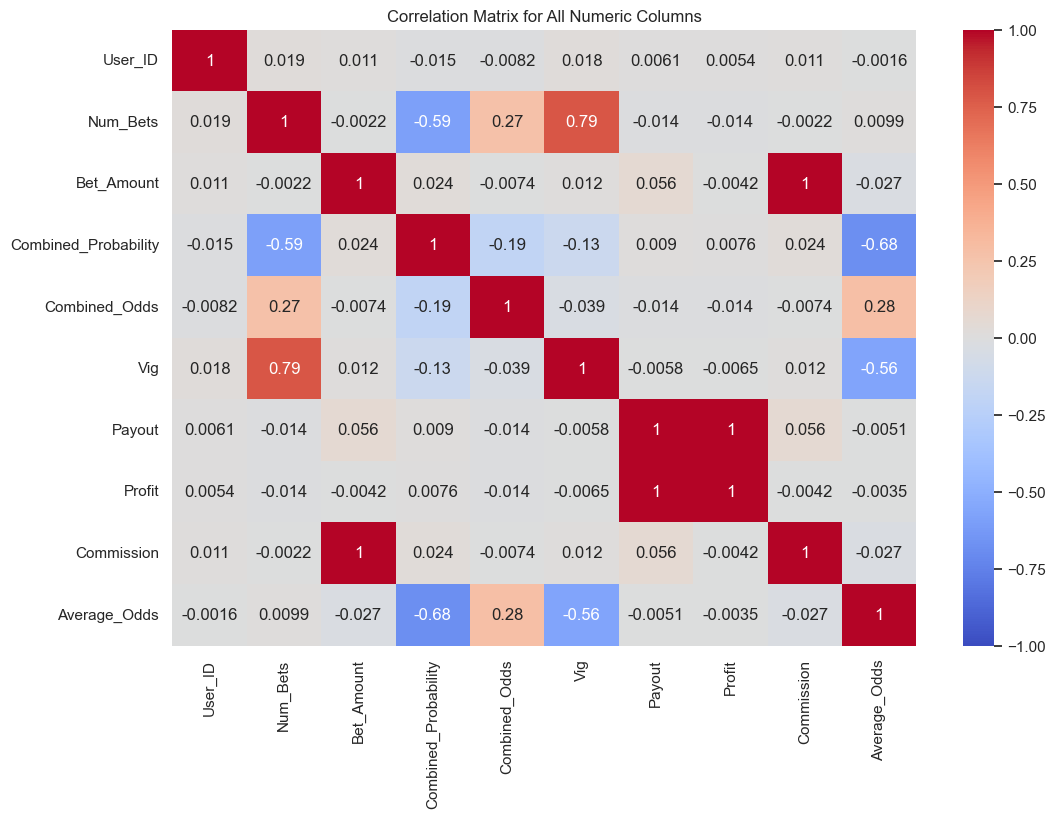

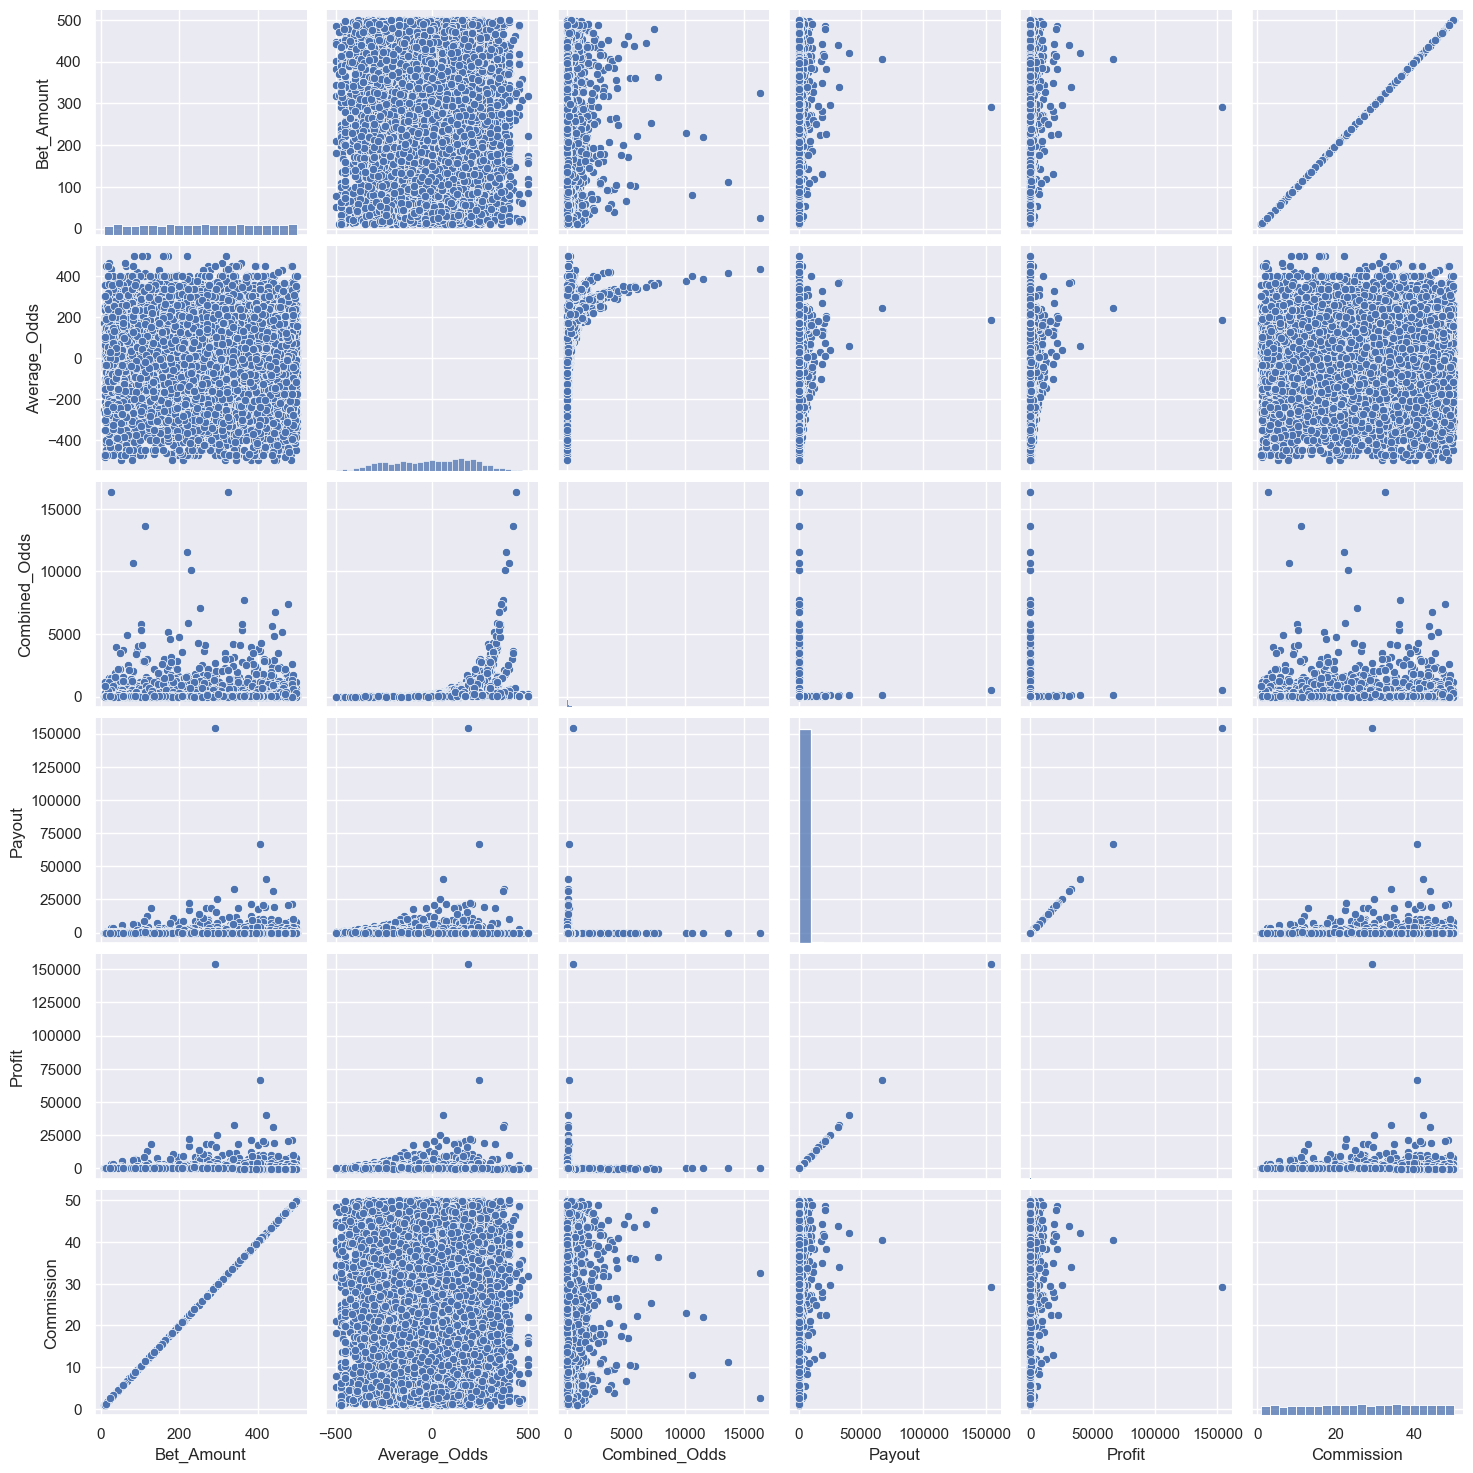

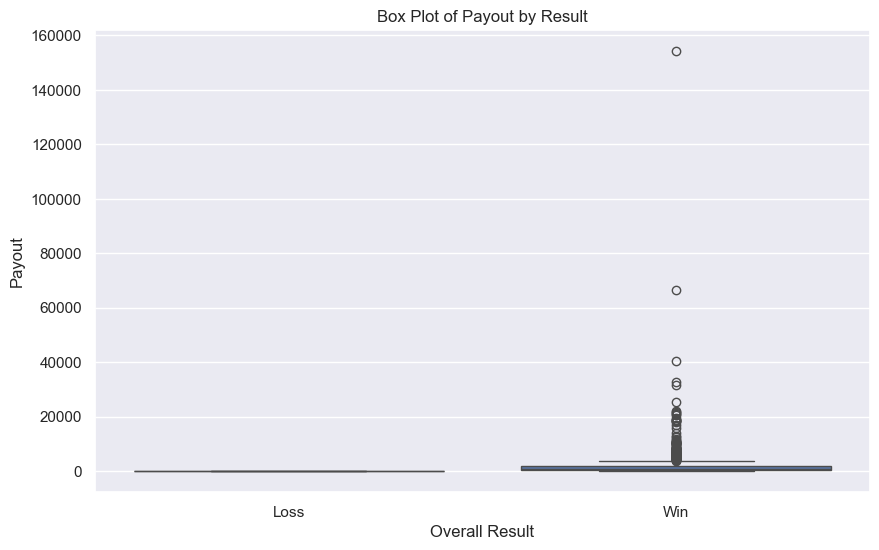

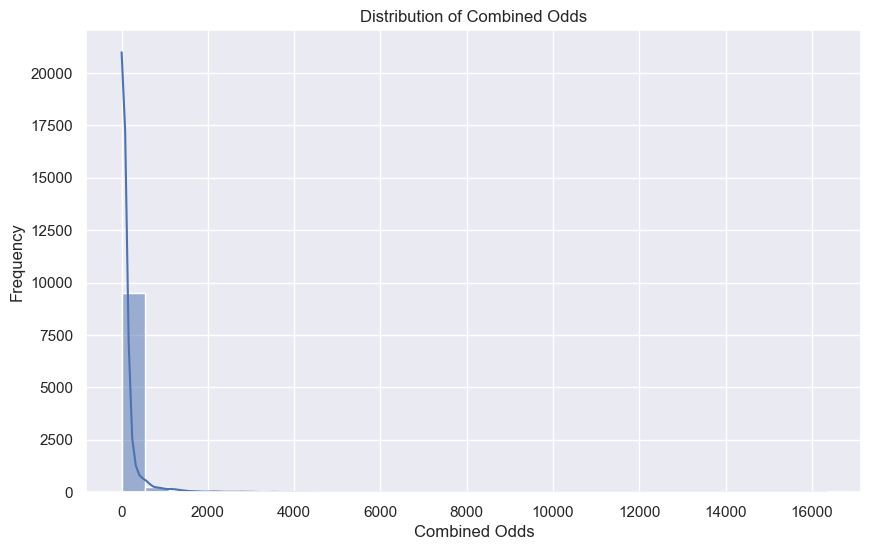

In [1092]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_mock is already created and contains the necessary data

# Calculate Average Odds for Each Entry
df_mock['Average_Odds'] = df_mock['Odds'].apply(lambda x: np.mean(x))

# Correlation Matrix for All Numeric Columns
correlation_matrix = df_mock.corr()

# Display the Correlation Matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Visualize the Correlation Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix for All Numeric Columns')
plt.show()

# Pair Plot for Selected Columns
selected_columns = ['Bet_Amount', 'Average_Odds', 'Combined_Odds', 'Payout', 'Profit', 'Commission']
sns.pairplot(df_mock[selected_columns])
plt.show()

# Box Plot of Payout by Result
plt.figure(figsize=(10, 6))
sns.boxplot(x='Overall_Result', y='Payout', data=df_mock)
plt.title('Box Plot of Payout by Result')
plt.xlabel('Overall Result')
plt.ylabel('Payout')
plt.show()

# Distribution of Combined Odds
plt.figure(figsize=(10, 6))
sns.histplot(df_mock['Combined_Odds'], bins=30, kde=True)
plt.title('Distribution of Combined Odds')
plt.xlabel('Combined Odds')
plt.ylabel('Frequency')
plt.show()

C:\Users\Mitch\AppData\Local\Temp\ipykernel_27800\3798670068.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_mock.corr()


Correlation Matrix:
                       User_ID  Num_Bets  Bet_Amount  Combined_Probability  \
User_ID               1.000000  0.019268    0.011291             -0.014616   
Num_Bets              0.019268  1.000000   -0.002152             -0.590126   
Bet_Amount            0.011291 -0.002152    1.000000              0.024266   
Combined_Probability -0.014616 -0.590126    0.024266              1.000000   
Combined_Odds        -0.008192  0.265896   -0.007398             -0.193010   
Vig                   0.018260  0.786559    0.011969             -0.130832   
Payout                0.006119 -0.014192    0.056127              0.009047   
Profit                0.005446 -0.014084   -0.004238              0.007595   
Commission            0.011291 -0.002152    1.000000              0.024266   
Average_Odds         -0.001556  0.009885   -0.027428             -0.681607   

                      Combined_Odds       Vig    Payout    Profit  Commission  \
User_ID                   -0.008192  0.0

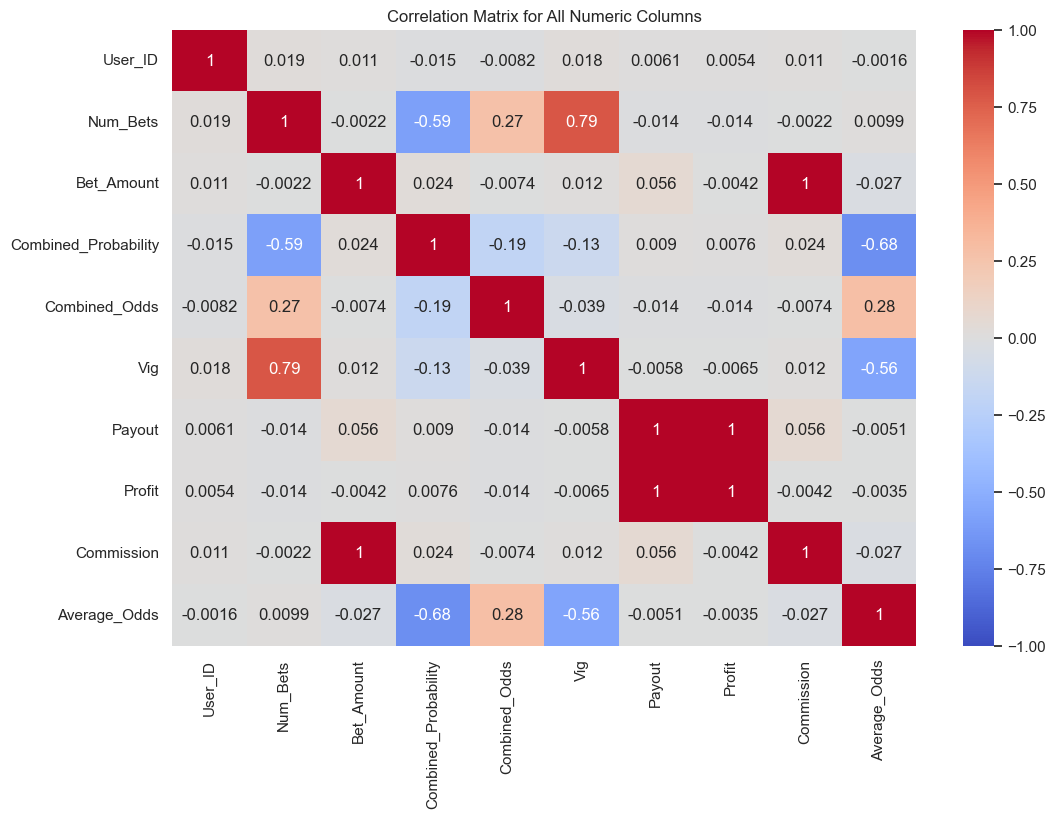

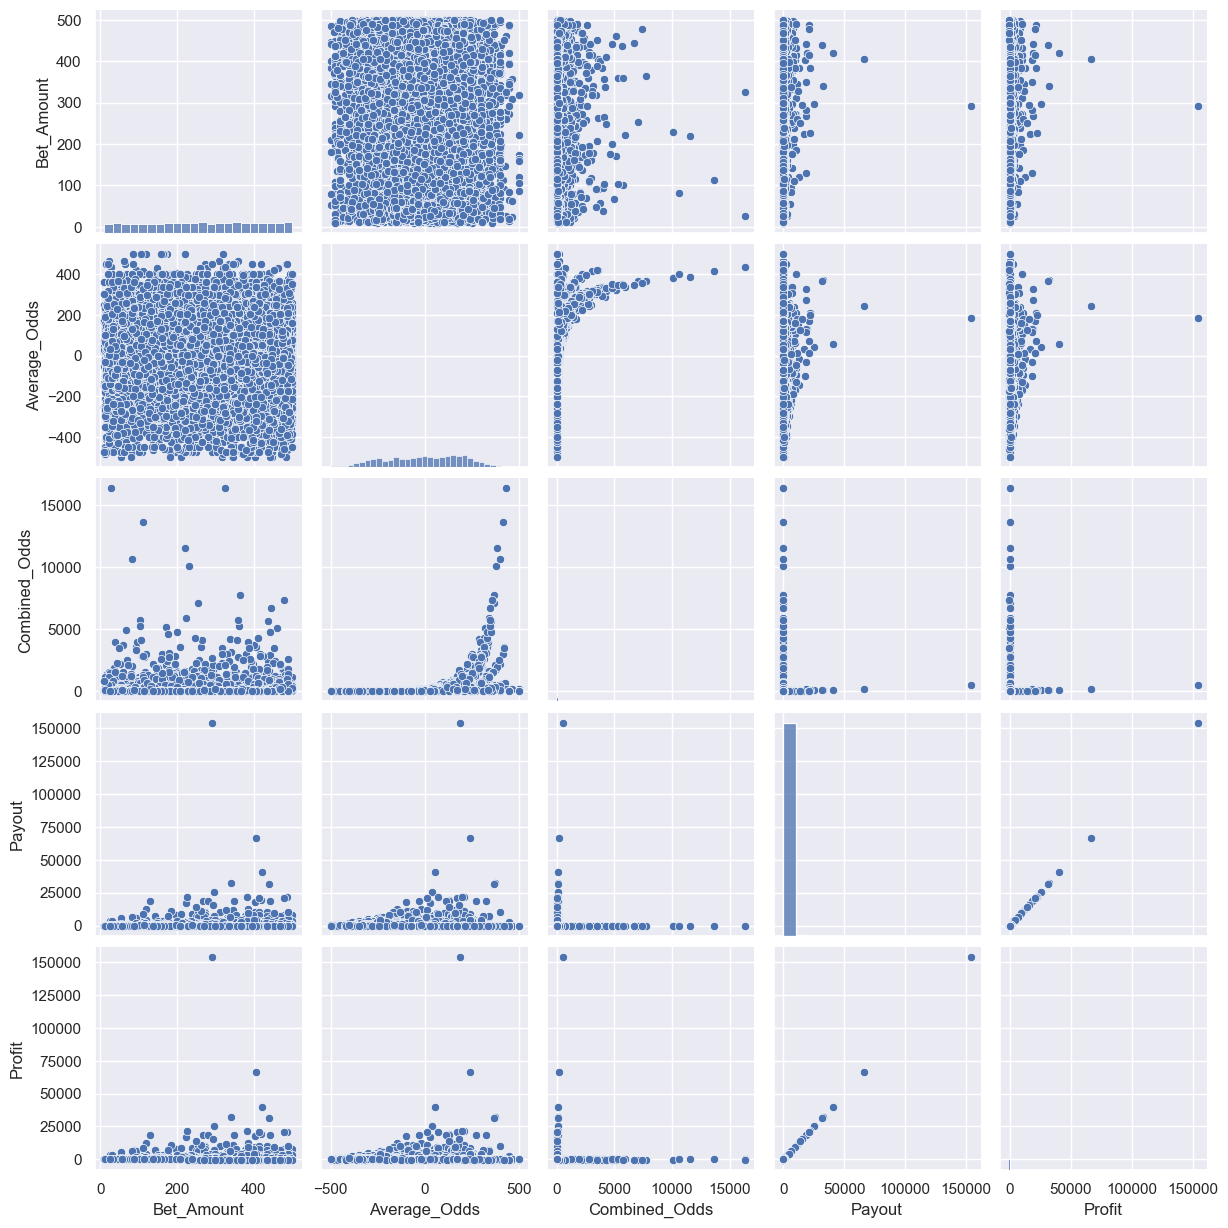

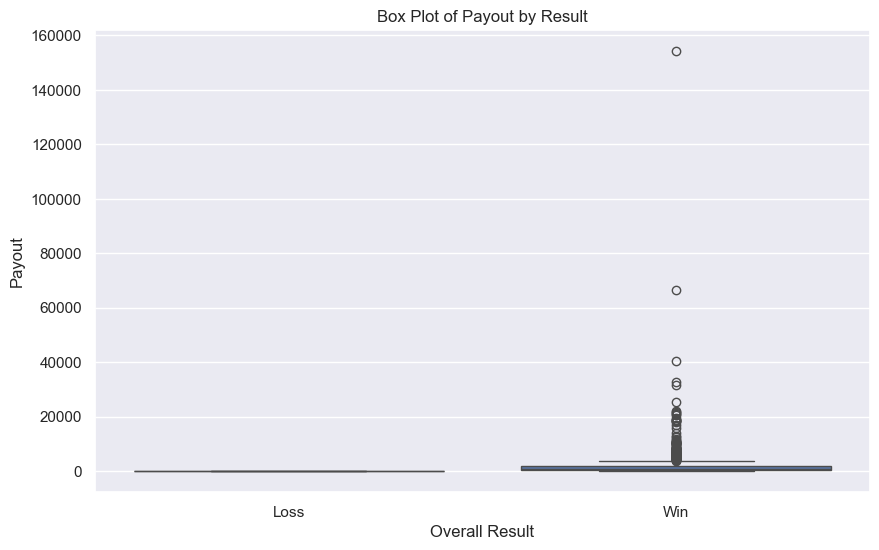

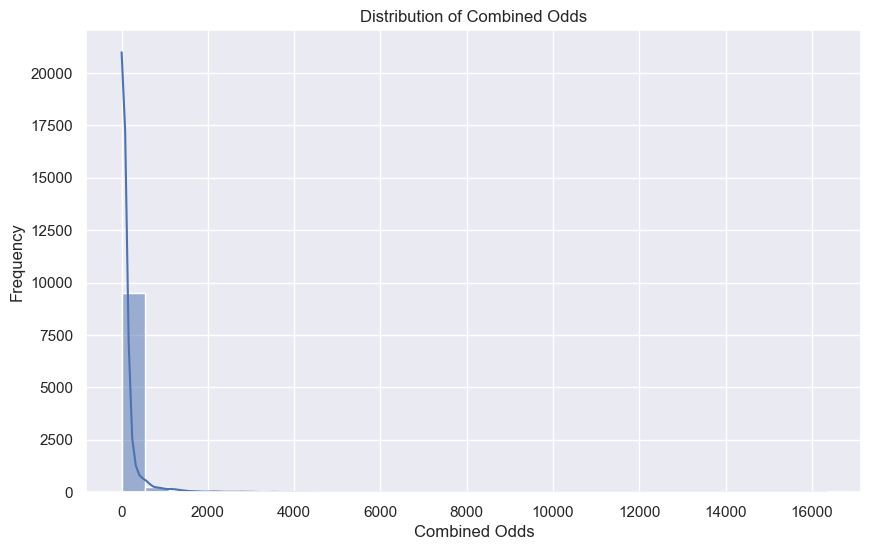

In [1093]:
# Assuming df_mock is already created and contains the necessary data

# Calculate Average Odds for Each Entry
df_mock['Average_Odds'] = df_mock['Odds'].apply(lambda x: np.mean(x))

# Correlation Matrix for All Numeric Columns
correlation_matrix = df_mock.corr()

# Display the Correlation Matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Visualize the Correlation Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix for All Numeric Columns')
plt.show()

# Pair Plot for Selected Columns (excluding 'Commission')
selected_columns = ['Bet_Amount', 'Average_Odds', 'Combined_Odds', 'Payout', 'Profit']
sns.pairplot(df_mock[selected_columns])
plt.show()

# Box Plot of Payout by Result
plt.figure(figsize=(10, 6))
sns.boxplot(x='Overall_Result', y='Payout', data=df_mock)
plt.title('Box Plot of Payout by Result')
plt.xlabel('Overall Result')
plt.ylabel('Payout')
plt.show()

# Distribution of Combined Odds
plt.figure(figsize=(10, 6))
sns.histplot(df_mock['Combined_Odds'], bins=30, kde=True)
plt.title('Distribution of Combined Odds')
plt.xlabel('Combined Odds')
plt.ylabel('Frequency')
plt.show()

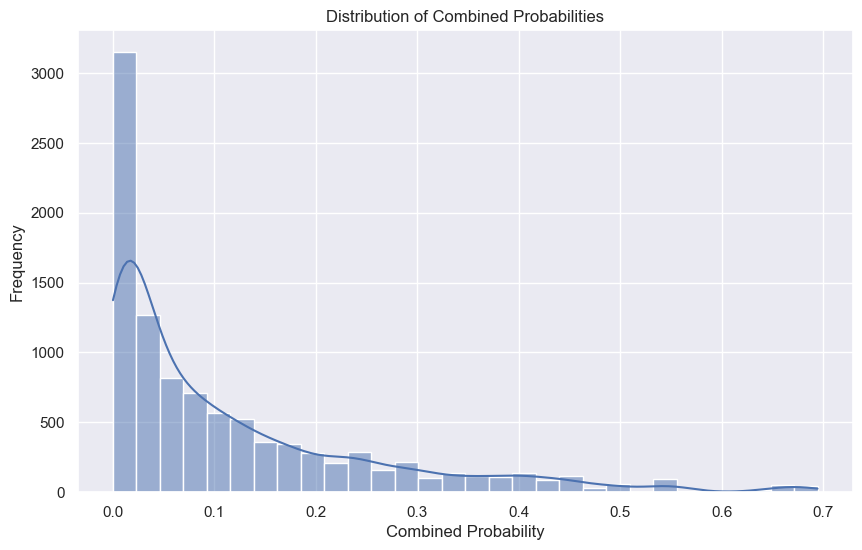

In [1094]:
# Visualize the Distribution of Combined Probabilities
plt.figure(figsize=(10, 6))
sns.histplot(df_mock['Combined_Probability'], bins=30, kde=True)
plt.title('Distribution of Combined Probabilities')
plt.xlabel('Combined Probability')
plt.ylabel('Frequency')
plt.show()


Combined Probability Bin Counts:
(0.0, 0.1]    6195
(0.1, 0.2]    1741
(0.2, 0.3]     957
(0.3, 0.4]     523
(0.4, 0.5]     366
(0.5, 0.6]     109
(0.6, 0.7]     109
(0.7, 0.8]       0
(0.8, 0.9]       0
(0.9, 1.0]       0
Name: Probability_Bin, dtype: int64

Combined Odds Bin Counts:
(0.0, 1632.96]          9884
(1632.96, 3265.92]        74
(3265.92, 4898.88]        23
(4898.88, 6531.84]         9
(6531.84, 8164.8]          4
(8164.8, 9797.76]          0
(9797.76, 11430.72]        2
(11430.72, 13063.68]       1
(13063.68, 14696.64]       1
(14696.64, 16329.6]        2
Name: Odds_Bin, dtype: int64


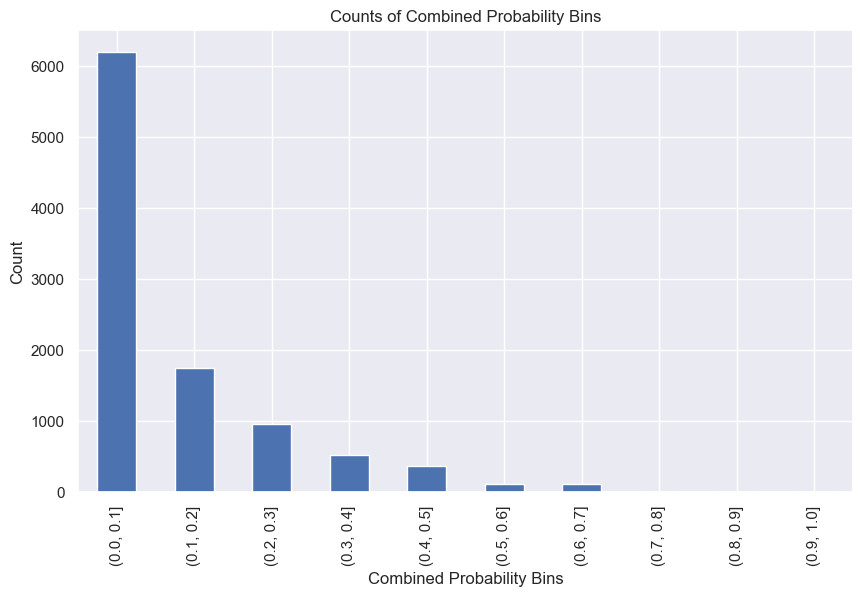

In [1095]:
# Assuming df_mock is already created and contains the necessary data

# Define bins for Combined Probabilities and Combined Odds
probability_bins = np.linspace(0, 1, 11)  # 10 bins from 0 to 1
odds_bins = np.linspace(0, df_mock['Combined_Odds'].max(), 11)  # 10 bins from 0 to max Combined Odds

# Bin the Combined Probabilities and Combined Odds
df_mock['Probability_Bin'] = pd.cut(df_mock['Combined_Probability'], bins=probability_bins)
df_mock['Odds_Bin'] = pd.cut(df_mock['Combined_Odds'], bins=odds_bins)

# Count the occurrences in each bin
probability_bin_counts = df_mock['Probability_Bin'].value_counts().sort_index()
odds_bin_counts = df_mock['Odds_Bin'].value_counts().sort_index()

# Display the bin counts
print("Combined Probability Bin Counts:")
print(probability_bin_counts)
print("\nCombined Odds Bin Counts:")
print(odds_bin_counts)

# Visualize the Binned Data
# Bar Plot for Combined Probability Bins
plt.figure(figsize=(10, 6))
probability_bin_counts.plot(kind='bar')
plt.title('Counts of Combined Probability Bins')
plt.xlabel('Combined Probability Bins')
plt.ylabel('Count')
plt.show()


Bets with Combined Probability > 0.5:
      User_ID  Num_Bets  Bet_Amount  Combined_Probability  Combined_Odds  \
130        33         2      270.85              0.533333       1.875000   
184        84         2      173.05              0.545455       1.833333   
192         1         2      305.29              0.681818       1.466667   
245        24         2      383.02              0.694444       1.440000   
339        76         2      478.55              0.545455       1.833333   
...       ...       ...         ...                   ...            ...   
9740        7         3      228.48              0.523636       1.909722   
9819       27         2      171.73              0.533333       1.875000   
9873       93         2      181.40              0.694444       1.440000   
9929       55         2      196.17              0.533333       1.875000   
9930       62         2       31.97              0.545455       1.833333   

         Payout     Profit  
130   507.84375  264

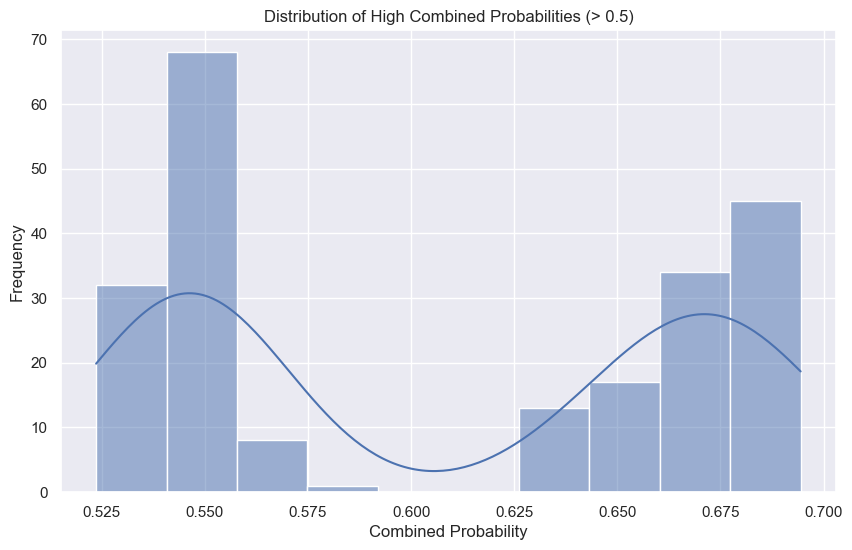

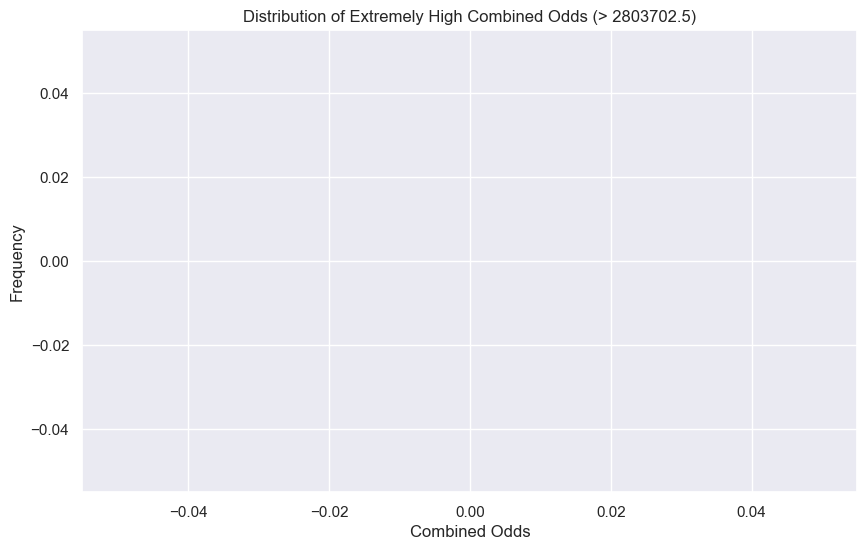

In [1096]:
high_prob_bets = df_mock[df_mock['Combined_Probability'] > 0.5]

# Display High Probability Bets
print("Bets with Combined Probability > 0.5:")
print(high_prob_bets[['User_ID', 'Num_Bets', 'Bet_Amount', 'Combined_Probability', 'Combined_Odds', 'Payout', 'Profit']])

# Analyze Bets with Extremely High Combined Odds (e.g., > 2803702.5)
high_odds_bets = df_mock[df_mock['Combined_Odds'] > 2803702.5]

# Display High Odds Bets
print("Bets with Extremely High Combined Odds:")
print(high_odds_bets[['User_ID', 'Num_Bets', 'Bet_Amount', 'Combined_Probability', 'Combined_Odds', 'Payout', 'Profit']])

# Visualize High Probability Bets
plt.figure(figsize=(10, 6))
sns.histplot(high_prob_bets['Combined_Probability'], bins=10, kde=True)
plt.title('Distribution of High Combined Probabilities (> 0.5)')
plt.xlabel('Combined Probability')
plt.ylabel('Frequency')
plt.show()

# Visualize High Odds Bets
plt.figure(figsize=(10, 6))
sns.histplot(high_odds_bets['Combined_Odds'], bins=10, kde=True)
plt.title('Distribution of Extremely High Combined Odds (> 2803702.5)')
plt.xlabel('Combined Odds')
plt.ylabel('Frequency')
plt.show()

Finer Combined Probability Bin Counts:
(0.0, 0.01]     1947
(0.01, 0.02]     992
(0.02, 0.03]     678
(0.03, 0.04]     513
(0.04, 0.05]     455
(0.05, 0.06]     386
(0.06, 0.07]     280
(0.07, 0.08]     351
(0.08, 0.09]     292
(0.09, 0.1]      301
(0.1, 0.11]      188
(0.11, 0.12]     254
(0.12, 0.13]     235
(0.13, 0.14]     190
(0.14, 0.15]     175
(0.15, 0.16]     125
(0.16, 0.17]     165
(0.17, 0.18]     172
(0.18, 0.19]     103
(0.19, 0.2]      134
Name: Finer_Probability_Bin, dtype: int64


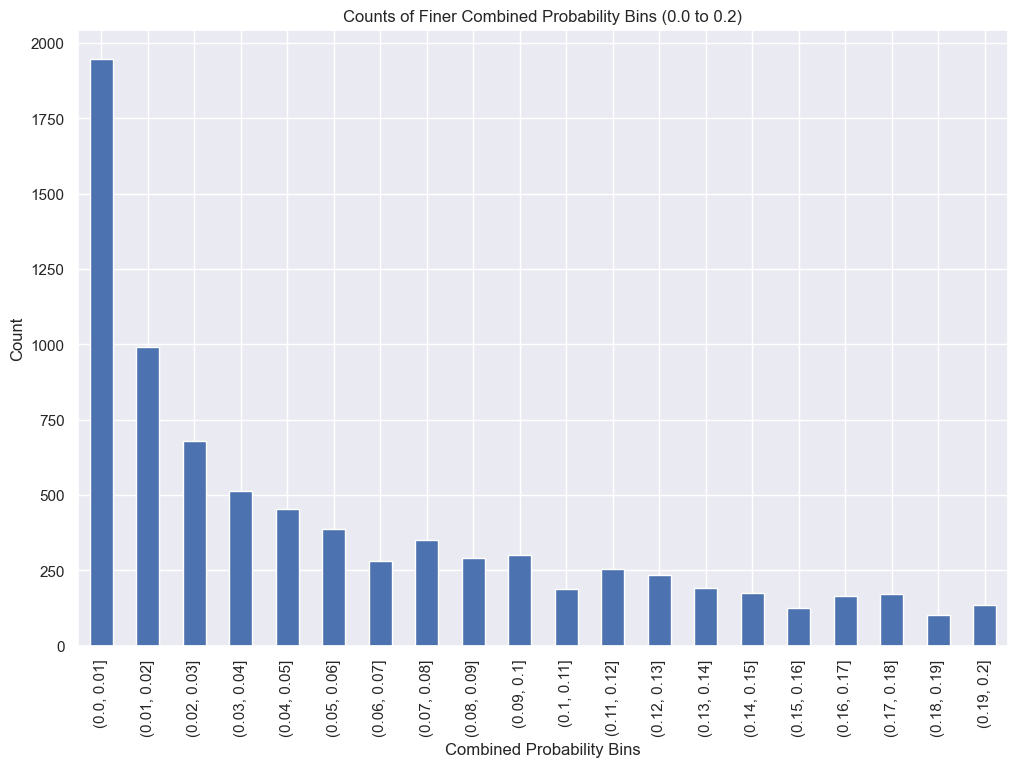

In [1097]:
# Define finer bins for Combined Probabilities from 0.0 to 0.2 with a step of 0.01
finer_probability_bins = np.arange(0, 0.21, 0.01)

# Bin the Combined Probabilities
df_mock['Finer_Probability_Bin'] = pd.cut(df_mock['Combined_Probability'], bins=finer_probability_bins)

# Count the occurrences in each bin
finer_probability_bin_counts = df_mock['Finer_Probability_Bin'].value_counts().sort_index()

# Display the bin counts
print("Finer Combined Probability Bin Counts:")
print(finer_probability_bin_counts)

# Visualize the Binned Data
# Bar Plot for Finer Combined Probability Bins
plt.figure(figsize=(12, 8))
finer_probability_bin_counts.plot(kind='bar')
plt.title('Counts of Finer Combined Probability Bins (0.0 to 0.2)')
plt.xlabel('Combined Probability Bins')
plt.ylabel('Count')
plt.show()

Finer Combined Probability Bin Counts:
(0.0, 0.01]     1947
(0.01, 0.02]     992
(0.02, 0.03]     678
(0.03, 0.04]     513
(0.04, 0.05]     455
(0.05, 0.06]     386
(0.06, 0.07]     280
(0.07, 0.08]     351
(0.08, 0.09]     292
(0.09, 0.1]      301
(0.1, 0.11]      188
(0.11, 0.12]     254
(0.12, 0.13]     235
(0.13, 0.14]     190
(0.14, 0.15]     175
(0.15, 0.16]     125
(0.16, 0.17]     165
(0.17, 0.18]     172
(0.18, 0.19]     103
(0.19, 0.2]      134
Name: Finer_Probability_Bin, dtype: int64
Bets with Combined Probability between 0-3%:
      User_ID  Num_Bets  Bet_Amount  Combined_Probability  Combined_Odds  \
1          93         6      417.26              0.012670      78.925000   
4          61         3      448.09              0.027685      36.120000   
6          83         5      276.68              0.005531     180.810000   
7          87         5      478.68              0.026608      37.583333   
10         88         3      241.88              0.019531      51.200000  

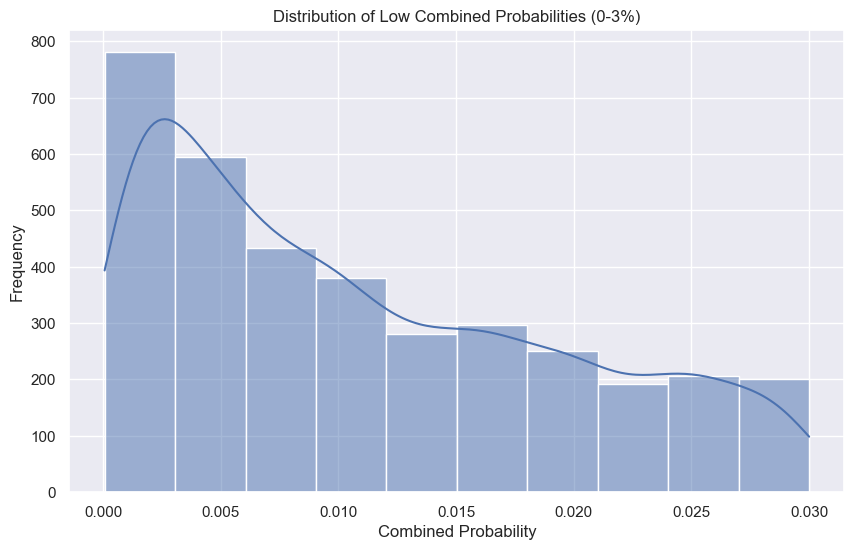

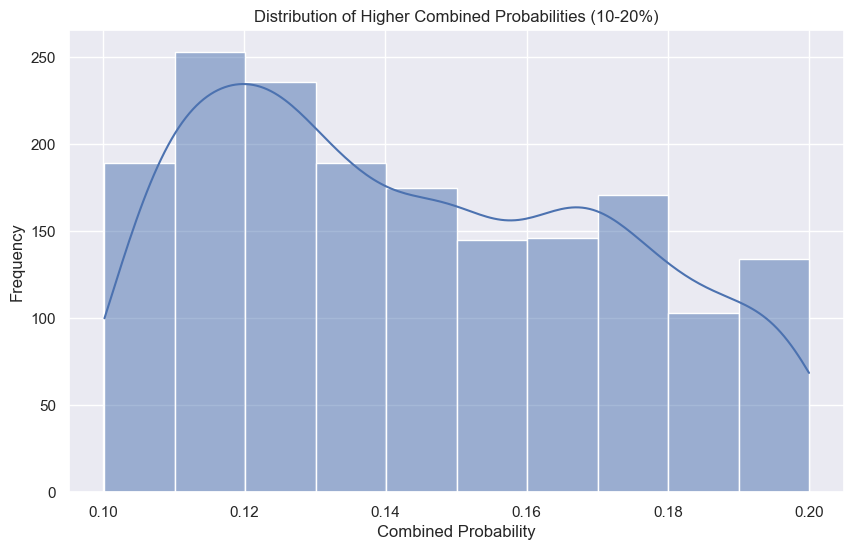

In [1098]:
# Define finer bins for Combined Probabilities from 0.0 to 0.2 with a step of 0.01
finer_probability_bins = np.arange(0, 0.21, 0.01)

# Bin the Combined Probabilities
df_mock['Finer_Probability_Bin'] = pd.cut(df_mock['Combined_Probability'], bins=finer_probability_bins)

# Count the occurrences in each bin
finer_probability_bin_counts = df_mock['Finer_Probability_Bin'].value_counts().sort_index()

# Display the bin counts
print("Finer Combined Probability Bin Counts:")
print(finer_probability_bin_counts)

# Analyze Bets in the 0-3% Probability Range
low_prob_bets = df_mock[(df_mock['Combined_Probability'] > 0.0) & (df_mock['Combined_Probability'] <= 0.03)]

# Display Low Probability Bets
print("Bets with Combined Probability between 0-3%:")
print(low_prob_bets[['User_ID', 'Num_Bets', 'Bet_Amount', 'Combined_Probability', 'Combined_Odds', 'Payout', 'Profit']])

# Compare with Higher Probability Bins (e.g., 0.1-0.2)
higher_prob_bets = df_mock[(df_mock['Combined_Probability'] > 0.1) & (df_mock['Combined_Probability'] <= 0.2)]

# Display Higher Probability Bets
print("Bets with Combined Probability between 10-20%:")
print(higher_prob_bets[['User_ID', 'Num_Bets', 'Bet_Amount', 'Combined_Probability', 'Combined_Odds', 'Payout', 'Profit']])

# Visualize Low Probability Bets
plt.figure(figsize=(10, 6))
sns.histplot(low_prob_bets['Combined_Probability'], bins=10, kde=True)
plt.title('Distribution of Low Combined Probabilities (0-3%)')
plt.xlabel('Combined Probability')
plt.ylabel('Frequency')
plt.show()

# Visualize Higher Probability Bets
plt.figure(figsize=(10, 6))
sns.histplot(higher_prob_bets['Combined_Probability'], bins=10, kde=True)
plt.title('Distribution of Higher Combined Probabilities (10-20%)')
plt.xlabel('Combined Probability')
plt.ylabel('Frequency')
plt.show()

Finer Combined Probability Bin Counts:
(0.0, 0.01]     1947
(0.01, 0.02]     992
(0.02, 0.03]     678
(0.03, 0.04]     513
(0.04, 0.05]     455
(0.05, 0.06]     386
(0.06, 0.07]     280
(0.07, 0.08]     351
(0.08, 0.09]     292
(0.09, 0.1]      301
(0.1, 0.11]      188
(0.11, 0.12]     254
(0.12, 0.13]     235
(0.13, 0.14]     190
(0.14, 0.15]     175
(0.15, 0.16]     125
(0.16, 0.17]     165
(0.17, 0.18]     172
(0.18, 0.19]     103
(0.19, 0.2]      134
Name: Finer_Probability_Bin, dtype: int64
Bets with Combined Probability between 0-3%:
      User_ID  Num_Bets  Bet_Amount  Combined_Probability  Combined_Odds  \
1          93         6      417.26              0.012670      78.925000   
4          61         3      448.09              0.027685      36.120000   
6          83         5      276.68              0.005531     180.810000   
7          87         5      478.68              0.026608      37.583333   
10         88         3      241.88              0.019531      51.200000  

C:\Users\Mitch\AppData\Local\Temp\ipykernel_27800\4109569174.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_prob_bets['Win'] = low_prob_bets['Overall_Result'].apply(lambda x: 1 if x == 'Win' else 0)
C:\Users\Mitch\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mitch\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packag

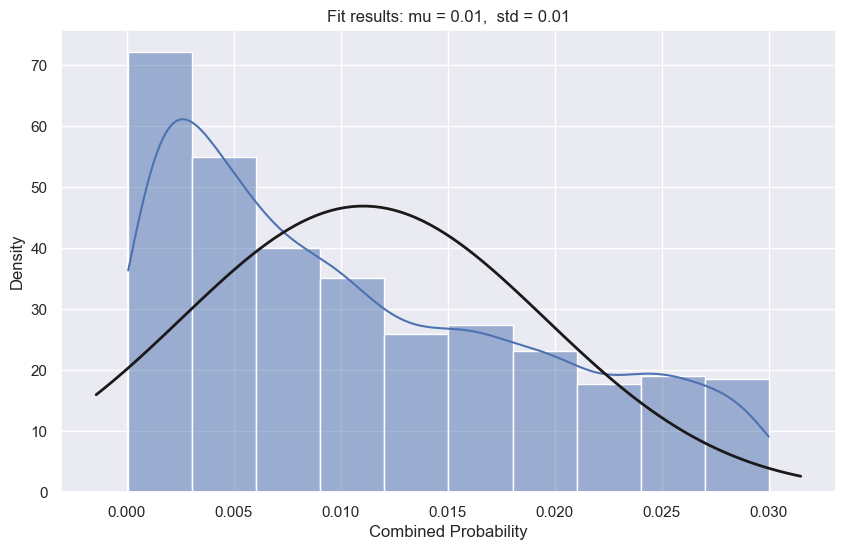

Success Rate by Combined Probability Bin:
Finer_Probability_Bin
(0.0, 0.01]     0.003595
(0.01, 0.02]    0.019153
(0.02, 0.03]    0.026549
(0.03, 0.04]         NaN
(0.04, 0.05]         NaN
(0.05, 0.06]         NaN
(0.06, 0.07]         NaN
(0.07, 0.08]         NaN
(0.08, 0.09]         NaN
(0.09, 0.1]          NaN
(0.1, 0.11]          NaN
(0.11, 0.12]         NaN
(0.12, 0.13]         NaN
(0.13, 0.14]         NaN
(0.14, 0.15]         NaN
(0.15, 0.16]         NaN
(0.16, 0.17]         NaN
(0.17, 0.18]         NaN
(0.18, 0.19]         NaN
(0.19, 0.2]          NaN
Name: Win, dtype: float64


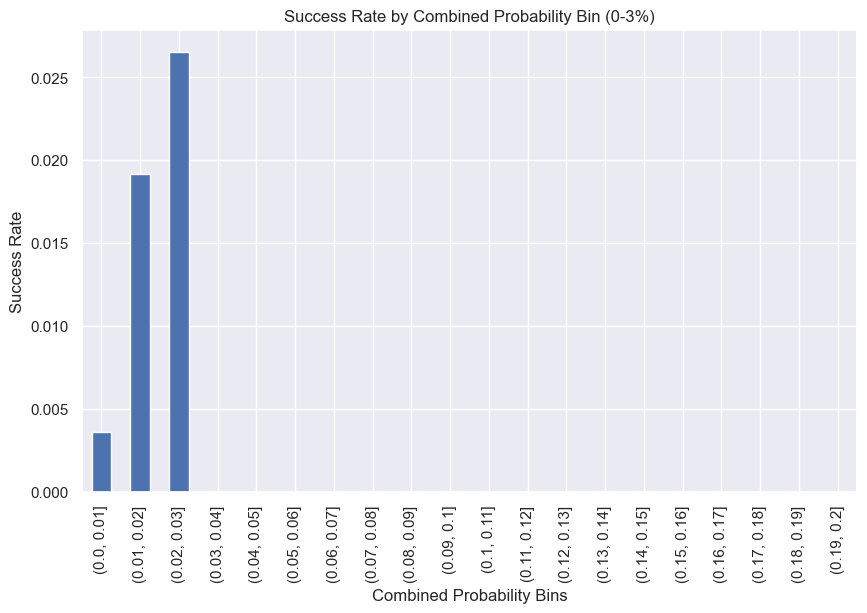

In [1099]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Assuming df_mock is already created and contains the necessary data

# Define finer bins for Combined Probabilities from 0.0 to 0.2 with a step of 0.01
finer_probability_bins = np.arange(0, 0.21, 0.01)

# Bin the Combined Probabilities
df_mock['Finer_Probability_Bin'] = pd.cut(df_mock['Combined_Probability'], bins=finer_probability_bins)

# Count the occurrences in each bin
finer_probability_bin_counts = df_mock['Finer_Probability_Bin'].value_counts().sort_index()

# Display the bin counts
print("Finer Combined Probability Bin Counts:")
print(finer_probability_bin_counts)

# Analyze Bets in the 0-3% Probability Range
low_prob_bets = df_mock[(df_mock['Combined_Probability'] > 0.0) & (df_mock['Combined_Probability'] <= 0.03)]

# Display Low Probability Bets
print("Bets with Combined Probability between 0-3%:")
print(low_prob_bets[['User_ID', 'Num_Bets', 'Bet_Amount', 'Combined_Probability', 'Combined_Odds', 'Payout', 'Profit', 'Overall_Result']])

# Correlation Analysis
correlation = low_prob_bets[['Combined_Probability', 'Payout']].corr()
print("Correlation between Combined Probability and Payout:")
print(correlation)

# Logistic Regression to Model Probability of Winning
low_prob_bets['Win'] = low_prob_bets['Overall_Result'].apply(lambda x: 1 if x == 'Win' else 0)
X = low_prob_bets[['Combined_Probability']]
y = low_prob_bets['Win']
log_reg = LogisticRegression()
log_reg.fit(X, y)
y_pred = log_reg.predict(X)
print("Logistic Regression Classification Report:")
print(classification_report(y, y_pred))
print("Logistic Regression Confusion Matrix:")
print(confusion_matrix(y, y_pred))

# Bell Curve (Normal Distribution) Comparison
plt.figure(figsize=(10, 6))
sns.histplot(low_prob_bets['Combined_Probability'], bins=10, kde=True, stat="density")
mu, std = norm.fit(low_prob_bets['Combined_Probability'])
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)
plt.xlabel('Combined Probability')
plt.ylabel('Density')
plt.show()

# Success Rate Analysis
success_rate = low_prob_bets.groupby('Finer_Probability_Bin')['Win'].mean()
print("Success Rate by Combined Probability Bin:")
print(success_rate)

# Visualize Success Rate
plt.figure(figsize=(10, 6))
success_rate.plot(kind='bar')
plt.title('Success Rate by Combined Probability Bin (0-3%)')
plt.xlabel('Combined Probability Bins')
plt.ylabel('Success Rate')
plt.show()

C:\Users\Mitch\AppData\Local\Temp\ipykernel_27800\3978422381.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_prob_bets['Win'] = low_prob_bets['Overall_Result'].apply(lambda x: 1 if x == 'Win' else 0)


Success Rate by Combined Probability Bin (0-3%):
Finer_Probability_Bin
(0.0, 0.01]     0.359527
(0.01, 0.02]    1.915323
(0.02, 0.03]    2.654867
Name: Win, dtype: float64


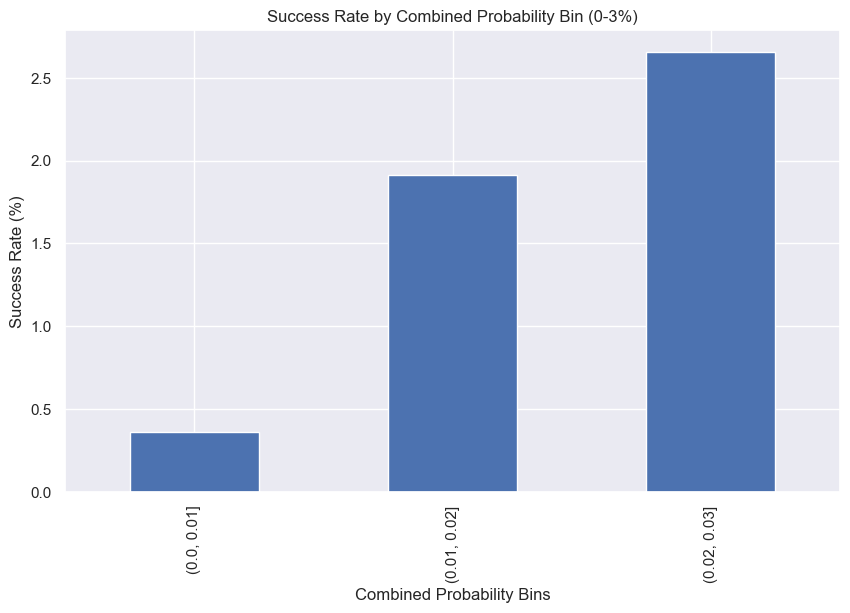

In [1100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_mock is already created and contains the necessary data

# Define finer bins for Combined Probabilities from 0.0 to 0.03 with a step of 0.01
finer_probability_bins = np.arange(0, 0.031, 0.01)

# Bin the Combined Probabilities
df_mock['Finer_Probability_Bin'] = pd.cut(df_mock['Combined_Probability'], bins=finer_probability_bins)

# Analyze Bets in the 0-3% Probability Range
low_prob_bets = df_mock[(df_mock['Combined_Probability'] > 0.0) & (df_mock['Combined_Probability'] <= 0.03)]

# Add a 'Win' column for success rate calculation
low_prob_bets['Win'] = low_prob_bets['Overall_Result'].apply(lambda x: 1 if x == 'Win' else 0)

# Success Rate Analysis
success_rate = low_prob_bets.groupby('Finer_Probability_Bin')['Win'].mean() * 100  # Convert to percentage

# Display Success Rate
print("Success Rate by Combined Probability Bin (0-3%):")
print(success_rate)

# Visualize Success Rate
plt.figure(figsize=(10, 6))
success_rate.plot(kind='bar')
plt.title('Success Rate by Combined Probability Bin (0-3%)')
plt.xlabel('Combined Probability Bins')
plt.ylabel('Success Rate (%)')
plt.show()

Combined Probability Bin Counts:
(0.0, 0.1]    6195
(0.1, 0.2]    1741
(0.2, 0.3]     957
(0.3, 0.4]     523
(0.4, 0.5]     366
(0.5, 0.6]     109
(0.6, 0.7]     109
(0.7, 0.8]       0
(0.8, 0.9]       0
(0.9, 1.0]       0
Name: Probability_Bin, dtype: int64


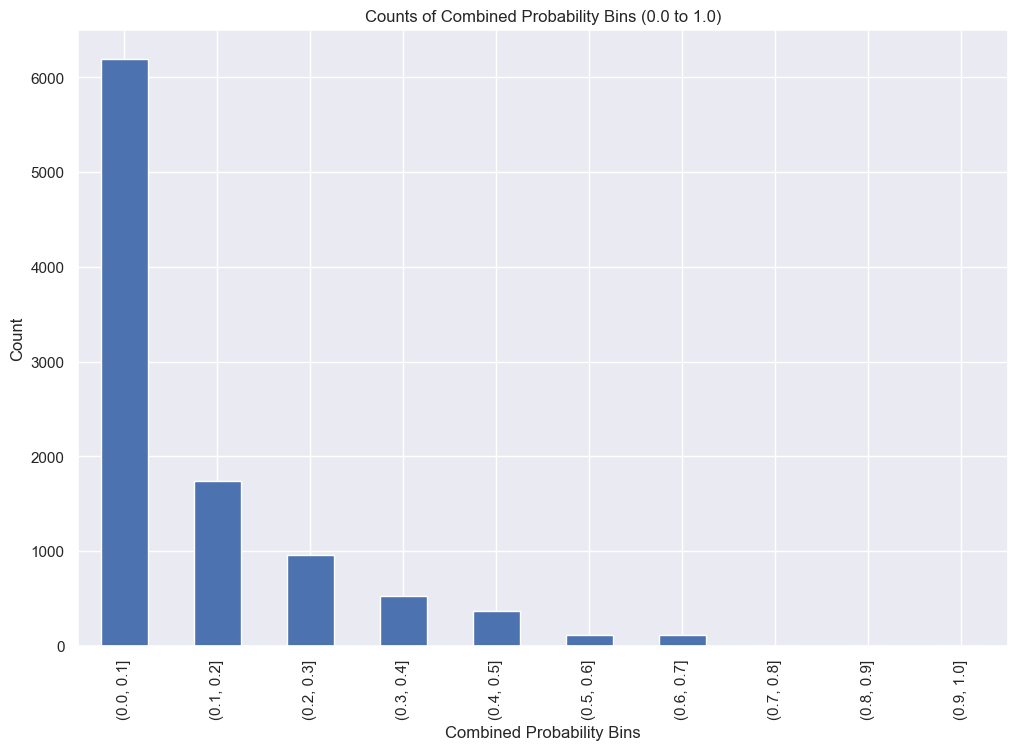

Success Rate by Combined Probability Bin (0.0 to 1.0):
Probability_Bin
(0.0, 0.1]     2.905569
(0.1, 0.2]    14.991384
(0.2, 0.3]    24.137931
(0.3, 0.4]    35.564054
(0.4, 0.5]    43.715847
(0.5, 0.6]    50.458716
(0.6, 0.7]    74.311927
(0.7, 0.8]          NaN
(0.8, 0.9]          NaN
(0.9, 1.0]          NaN
Name: Win, dtype: float64


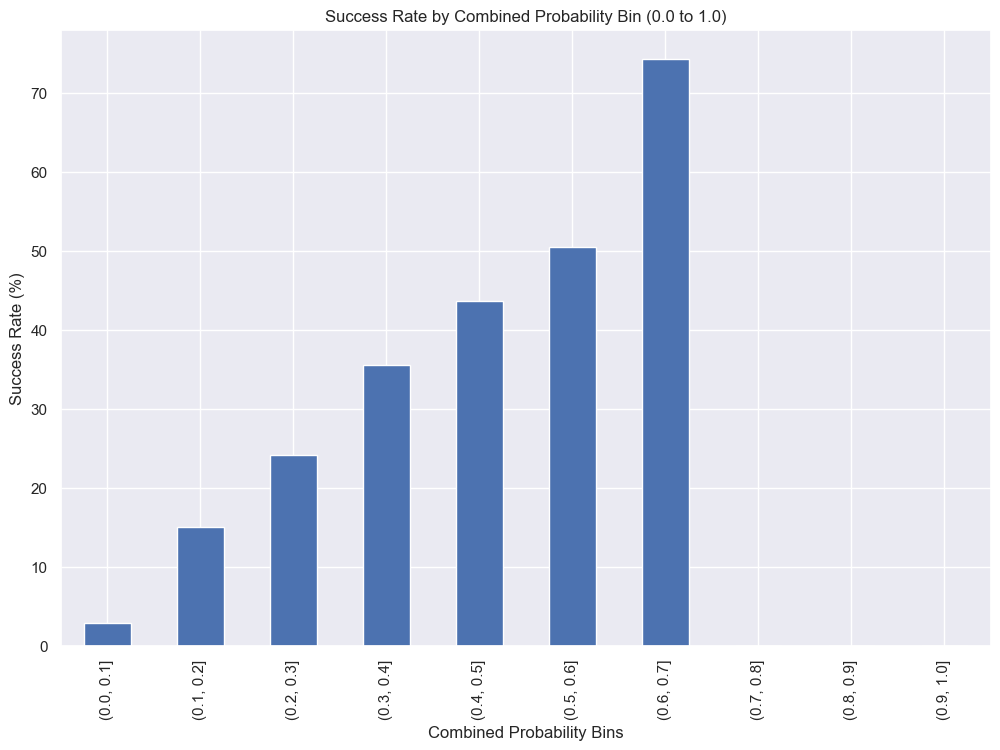

In [1101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_mock is already created and contains the necessary data

# Define finer bins for Combined Probabilities from 0.0 to 1.0 with a step of 0.1
probability_bins = np.arange(0, 1.1, 0.1)

# Bin the Combined Probabilities
df_mock['Probability_Bin'] = pd.cut(df_mock['Combined_Probability'], bins=probability_bins)

# Count the occurrences in each bin
probability_bin_counts = df_mock['Probability_Bin'].value_counts().sort_index()

# Display the bin counts
print("Combined Probability Bin Counts:")
print(probability_bin_counts)

# Visualize the Binned Data
# Bar Plot for Combined Probability Bins
plt.figure(figsize=(12, 8))
probability_bin_counts.plot(kind='bar')
plt.title('Counts of Combined Probability Bins (0.0 to 1.0)')
plt.xlabel('Combined Probability Bins')
plt.ylabel('Count')
plt.show()

# Success Rate Analysis for All Bins
df_mock['Win'] = df_mock['Overall_Result'].apply(lambda x: 1 if x == 'Win' else 0)
success_rate_all_bins = df_mock.groupby('Probability_Bin')['Win'].mean() * 100  # Convert to percentage

# Display Success Rate
print("Success Rate by Combined Probability Bin (0.0 to 1.0):")
print(success_rate_all_bins)

# Visualize Success Rate for All Bins
plt.figure(figsize=(12, 8))
success_rate_all_bins.plot(kind='bar')
plt.title('Success Rate by Combined Probability Bin (0.0 to 1.0)')
plt.xlabel('Combined Probability Bins')
plt.ylabel('Success Rate (%)')
plt.show()

In [1102]:
import numpy as np

# Function to convert American odds to implied probability
def american_to_implied_probability(odds):
    if odds > 0:
        return 100 / (odds + 100)
    else:
        return abs(odds) / (abs(odds) + 100)

# Given odds
odds = [500, 115, 110, -400, -400, -150]

# Convert to implied probabilities
implied_probabilities = [american_to_implied_probability(odd) for odd in odds]
print("Implied Probabilities:", implied_probabilities)

# Calculate combined implied probability
combined_probability = np.prod(implied_probabilities)
print("Combined Implied Probability:", combined_probability)

# Convert combined implied probability to combined odds
combined_odds = 1 / combined_probability if combined_probability != 0 else np.inf
print("Combined Odds:", combined_odds)

Implied Probabilities: [0.16666666666666666, 0.46511627906976744, 0.47619047619047616, 0.8, 0.8, 0.6]
Combined Implied Probability: 0.014174972314507197
Combined Odds: 70.546875


In [1103]:
import nbformat

# Define the path to the original notebook
original_notebook_path = 'tester.ipynb'

# Read the original notebook
with open(original_notebook_path, 'r', encoding='utf-8') as f:
    original_notebook = nbformat.read(f, as_version=4)

# Print the cells with their indices and execution counts to identify the starting point
for i, cell in enumerate(original_notebook.cells):
    execution_count = cell.get('execution_count', 'N/A')
    print(f"Cell {i} [Execution Count: {execution_count}]: {cell['cell_type']}")
    print(cell['source'])
    print("-" * 80)

Cell 0 [Execution Count: None]: code

--------------------------------------------------------------------------------
Cell 1 [Execution Count: 856]: code
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns   # for making plots with seaborn
sns.set_theme(style="darkgrid")

def get_data():
    # Get the current working directory
    base_path = os.getcwd()
    # Construct the full path to the CSV file
    file_path = os.path.join(base_path, 'data', 'user_bet_breakdown.csv')
    
    # Check if the file exists at the constructed path
    if not os.path.exists(file_path):
        # If not, adjust the path assuming the script is run from the notebooks directory
        file_path = os.path.join(base_path, '..', 'data', 'user_bet_breakdown.csv')
    
    # Read the CSV file into a DataFrame
    data = pd.read_csv(file_path)
    return data 

# Read the CSV file into a DataFrame
df = get_data()

# Display the first few rows of the DataFrame t

In [1108]:
import nbformat

# Define the path to the original notebook and the new notebook
original_notebook_path = 'tester.ipynb'
new_notebook_path = 'new_notebook.ipynb'

# Read the original notebook
with open(original_notebook_path, 'r', encoding='utf-8') as f:
    original_notebook = nbformat.read(f, as_version=4)

# Define the starting point (cell index) from which to copy cells
start_index = 86  # Cell index corresponding to execution count [978]

# Select cells from the starting point down
selected_cells = original_notebook.cells[start_index:]

# Debug print to verify selected cells
print(f"Selected {len(selected_cells)} cells starting from index {start_index}")

# Create a new notebook with the selected cells
new_notebook = nbformat.v4.new_notebook()
new_notebook.cells = selected_cells

# Debug print to verify new notebook cells
print(f"New notebook has {len(new_notebook.cells)} cells")

# Write the new notebook to a file
with open(new_notebook_path, 'w', encoding='utf-8') as f:
    nbformat.write(new_notebook, f)

print(f"New notebook created: {new_notebook_path}")

Selected 20 cells starting from index 86
New notebook has 20 cells
New notebook created: new_notebook.ipynb
